## Class 02 & Class 03
Notebook for classes 02 and 03. Exercises for class 02 shown first

### Setup: Download, Import Packages & Load RAW Data

In [72]:
# setup
%pip install pandas matplotlib seaborn scikit-learn numpy --quiet

import pathlib 
import pandas as pd 
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


In [73]:
path = pathlib.Path.cwd()
datapath = path.parents[4] / "data" / "class_01" / "bikes.csv"
df = pd.read_csv(datapath)

### 2.0 Exercises
1. Create a folder called `group-x` within `nbs/class_02`, `cd` into it and work within that today
2. Choose an outcome variable for a regression problem. On the basis of this, define **which of the evaluation metrics** could be suitable. Evaluation metrics can be computed using scikit-learn: https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics 
3. (a) If you are in the bike sharing group, split your dataset into a training/validation/test set using later time points as validation/test set. Validation and test set should be 15% of your data each. (b) If you are in the personality group, using sklearn's `train_test_split` function, create a 70/15/15 random split of your data.
    - Remember to set a seed (`random_state`) when you do so. Let's all use the same (the classic `random_state=42`)
    - Save these datasets as separate csv files in a subfolder called `data`
4. Look at your outcome and predictors: do you want to transform them in any way?
5. Estimate the performance of a dummy baseline (i.e., the mean model) on all splits
6. Now look at your predictors: do they need any preprocessing? Any transformations? Removal of "bad" data points?
7. Fit the other models using KKN (sklearn's `KNeighborsRegressor`: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) and linear models (`LinearRegressor`: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). Save the fitted model object (with a meaningful name) using `pickle` (https://scikit-learn.org/stable/model_persistence.html) in a subfolder called `model`.
8. Once you are done, evaluate all models on both the training and the validation set and visualize the scores

#### 2.2 Creating an Outcome & Transforming Data
Technically transforming data is exercise 2.4 :)) 

In [74]:
# define outcome
df["proportion_casual_reg"] = df["casual"]/df["cnt"]

**Which evaluation metrics would be suitable?** <br> We'll chose R-squared as we are interested in a general metric on how good our model fits to the data and not necessarily interested in how our model fares on individual data points. Therefore it would not make sense to use RMSE/MSE as they are scale-dependent

In [75]:
# define cols that need one-hot dummy variables
columns = ["season", "mnth", "weekday", "weathersit"]

# make one hot dummy variable
df = pd.get_dummies(df, columns=columns, prefix=columns, dtype=int)

#### 2.3 Split Data & Save It!

In [76]:
len_df = len(df)

# define the split percentage
split_size = 0.15

# get the absolute number of rows that equals to our split size (use int to rm. decimal)
n_rows = int(len_df * split_size)

# define test
test_df = df.iloc[-n_rows:, :]

# define train and val combined
train_val_df = df.iloc[:-n_rows, :]

# subset train from only the train and val 
train_df = train_val_df.iloc[:-n_rows, :]

# subset val from only the train and val
val_df = train_val_df.iloc[-n_rows:, :]

In [77]:
# save dataset
save_path = path.parents[2] / "nbs" / "class_02" / "group-RMDS" / "data"
save_path.mkdir(parents=True, exist_ok=True)

train_df.to_csv(save_path / "train_bikes.csv", index=False)
val_df.to_csv(save_path / "val_bikes.csv", index=False)
test_df.to_csv(save_path / "test_bikes.csv", index=False)

#### 2.5- 2.7 Model Training!

In [78]:
## create X_splits ## 
redundant_cols = ["proportion_casual_reg", "registered", "casual", "cnt", "dteday"]
X_train = train_df.drop(redundant_cols, axis=1)
X_val = val_df.drop(redundant_cols, axis=1)
X_test = test_df.drop(redundant_cols, axis=1)

## create y_splits ## 
y_train = train_df["proportion_casual_reg"].values
y_val = val_df["proportion_casual_reg"].values
y_test = test_df["proportion_casual_reg"].values

In [79]:
def evaluate(model, X, y, nsplit, model_name, constant_value=None):
    ''' Evaluates the performance of a model 
    Args:
        model (sklearn.Estimator): fitted sklearn estimator
        X (np.array): predictors
        y (np.array): true outcome
        nsplit (str): name of the split
        model_name (str): string id of the model
        constant_value (int or None): relevant if the model predicts a constant
    '''
    performances = []

    if constant_value is not None:
        preds = np.array([constant_value] * y.shape[0])
    else:
        preds = model.predict(X)
    r2 = r2_score(y, preds)
    performance = np.sqrt(mean_squared_error(y, preds))
    performances.append({'model': model_name,
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

    return performances

def evaluate_across_splits(model, X_splits, y_splits, split_names, model_name, constant_value=None):
    '''
    Evaluates the performance of a model across different splits
    Args:
        model (sklearn.Estimator): fitted sklearn estimator
        X_splits (list): list of arrays containing predictors for each split
        y_splits (list): list of arrays containing true outcome for each split
        split_names (list): list of split names
        model_name (str): string id of the model
        constant_value (int or None): relevant if the model predicts a constant
    Returns:
        list: list of performance metrics for each split
    '''
    performances = []

    for X, y, split_name in zip(X_splits, y_splits, split_names):
        performance_metrics = evaluate(model, X, y, split_name, model_name, constant_value)
        performances.extend(performance_metrics)

    return performances

In [80]:
performance_df = pd.DataFrame()

##### Dummy Model

In [81]:
dummy_performances = evaluate_across_splits(
                                            model=None, 
                                            X_splits=[X_train, X_val, X_test],
                                            y_splits=[y_train, y_val, y_test],
                                            split_names=["train", "val", "test"],
                                            model_name="dummy",
                                            constant_value=y_train.mean()
                                            )

performance_df = performance_df._append(dummy_performances)
performance_df

,model,split,rmse,r2
0,dummy,train,0.1426,0.0000
1,dummy,val,0.1224,-0.0753
2,dummy,test,0.1200,-0.0734


## Other Models
 ```
    - Model 0 (dummy baseline): Always predict the average of Y in the training data
    - Model 1: Predict based on a linear model with `instant` as the only predictor
    - Model 2: Model including weather info (temperature, windspeed) and temporal parameters (e.g., `season`, `weekday`) as predictors
    - Model 3: A "kitchen sink" model, will all predictors included
```

In [82]:
models_savepath = path.parents[3] / "models"
models_savepath

PosixPath('/work/code/models')

### Model 1

In [83]:
def convert_single_col_to_array(X, col="instant"):
    '''
    convert single col to predictor array 
    '''
    X_converted =  X[col].to_numpy().reshape(-1, 1)

    return X_converted

X_instant_predictors = {}

for X, name in zip([X_train, X_val, X_test], ["train", "val", "test"]):
    X_instant_predictors[name] = convert_single_col_to_array(X, col="instant")

X_instant_predictors.keys()

dict_keys(['train', 'val', 'test'])

In [84]:
instant_linear = LinearRegression().fit(X_instant_predictors["train"], y_train)

In [85]:
X_instant_splits = [X_instant_predictors["train"], X_instant_predictors["val"], X_instant_predictors["test"]]

instant_performances = evaluate_across_splits(
                                            model=instant_linear, 
                                            X_splits=X_instant_splits,
                                            y_splits=[y_train, y_val, y_test],
                                            split_names=["train", "val", "test"],
                                            model_name="instant_linear"
                                            )

performance_df = performance_df._append(instant_performances)

performance_df

,model,split,rmse,r2
0,dummy,train,0.1426,0.0000
1,dummy,val,0.1224,-0.0753
2,dummy,test,0.1200,-0.0734
0,instant_linear,train,0.1425,0.0023
1,instant_linear,val,0.1270,-0.1575
2,instant_linear,test,0.1161,-0.0053


## Model 2

In [86]:
weather_cols = ["temp", "hum", "season_1", "season_2", "season_3", "season_4"]
X_weather_train, X_weather_val, X_weather_test = X_train[weather_cols].values, X_val[weather_cols].values, X_test[weather_cols].values

In [87]:
weather_linear = LinearRegression().fit(X_weather_train, y_train)
X_weather_splits = [X_weather_train, X_weather_val, X_weather_test]

weather_performances = evaluate_across_splits(
                                            model=weather_linear, 
                                            X_splits=X_weather_splits,
                                            y_splits=[y_train, y_val, y_test],
                                            split_names=["train", "val", "test"],
                                            model_name="weather_linear"
                                            )

performance_df = performance_df._append(weather_performances)
performance_df

,model,split,rmse,r2
0,dummy,train,0.1426,0.0000
1,dummy,val,0.1224,-0.0753
2,dummy,test,0.1200,-0.0734
0,instant_linear,train,0.1425,0.0023
1,instant_linear,val,0.1270,-0.1575
2,instant_linear,test,0.1161,-0.0053
0,weather_linear,train,0.1287,0.1857
1,weather_linear,val,0.1167,0.0224
2,weather_linear,test,0.1088,0.1178


<Axes: xlabel='rmse', ylabel='model'>

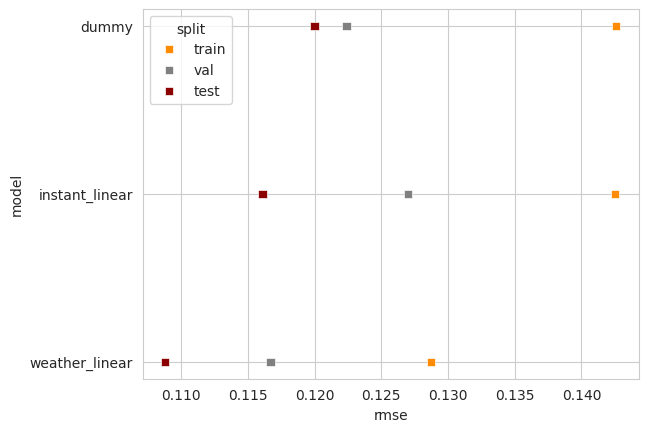

In [88]:
sns.set_style('whitegrid')
sns.scatterplot(data=performance_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])

<Axes: xlabel='r2', ylabel='model'>

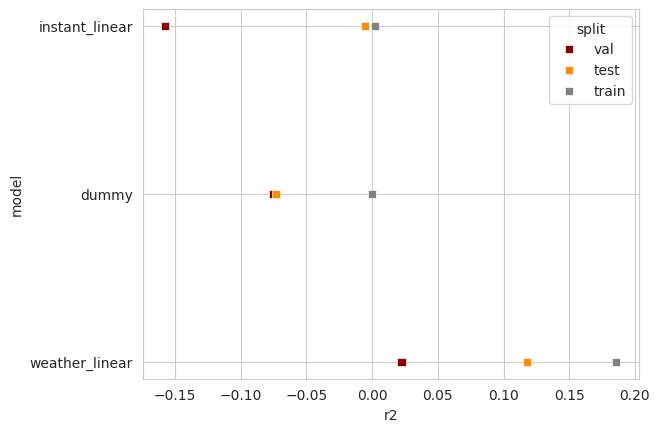

In [89]:
sns.scatterplot(data=performance_df.sort_values(by='r2', ascending=True), 
                y='model', 
                x='r2', 
                marker='s', 
                hue='split', palette=['darkred', 'darkorange', 'grey'])

##### KNNs

In [90]:
# instant predictor KNNS
for k in [3,5,10,20,30]:
    neigh = KNeighborsRegressor(n_neighbors=k)
    neigh.fit(X_instant_predictors["train"], y_train)

    instant_performances = evaluate_across_splits(
                                            model=neigh, 
                                            X_splits=X_instant_splits,
                                            y_splits=[y_train, y_val, y_test],
                                            split_names=["train", "val", "test"],
                                            model_name=f"instant_KNN_{k}"
                                            )

    performance_df = performance_df._append(instant_performances)

# weather predictors KNNs
for k in [3,5,10,20,30]:
    neigh = KNeighborsRegressor(n_neighbors=k)
    neigh.fit(X_weather_train, y_train)

    weather_performances = evaluate_across_splits(
                                            model=neigh, 
                                            X_splits=X_weather_splits,
                                            y_splits=[y_train, y_val, y_test],
                                            split_names=["train", "val", "test"],
                                            model_name=f"weather_KNN_{k}"
                                            )

    performance_df = performance_df._append(weather_performances)

<Axes: xlabel='rmse', ylabel='model'>

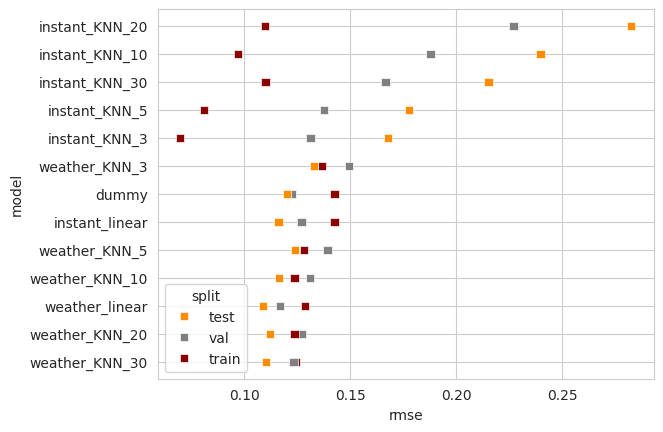

In [91]:
sns.set_style('whitegrid')
sns.scatterplot(data=performance_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])

### 3.0 Exercises

Gather in the same group as last week, and please go through the following steps:
1. Look back at last week's notebook. If you have not applied any transformation to your input because you did not have time, spend some time thinking about whether it would make sense to do so. You can find relevant transformations in `scikit-learn`: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing. You will probably mostly be interested in `StandardScaler` and `MinMaxScaler`
2. Look at the performance of the models you've fitted last week: what is the best model? Do you see any evidence of overfitting?
3. Fit your maximal models with `Lasso` (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso) and `Ridge` (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) estimators instead of `LinearRegression`. Make sure you look at the documentation to understand what these do. Fit multiple models with multiple values of alpha and store the outputs;
4. Plot the performance of your models against your linear and KNN models from last week. Does the performance of the model on the validation set improve with regularization?
5. For both `Lasso` and `Ridge` models, plot the value of the coefficients as a function of alpha. You can access the coefficients for a fitted `model` through `model.coef_`. What do you notice in terms of how LASSO versus Ridge behave? (Look at `example.ipynb` for inspiration)
6. Finally, if any models are doing better than the linear model without regularization, select the best `Ridge` and the best `Lasso` model, and plot their coefficients, alongsize coefficients from the simple linear models. How do estimates change with regularization? Which values have changed the most? Do you have any hypothesis as to why?

Scale has not been done as most biking data is already normalised (e.g., temp, atemp)

#### 3.3 Fitting Models with Ridge and Lasso

In [92]:
perf_dfs = []

models = {} # storing fitted models in the next chunk
models['linear-0.0'] = reg

for alpha in [0.01, 0.1, 0.2, 0.5, 1.0, 20.0, 10.0, 100.0, 1000.0]:
    for est in [Lasso, Ridge]:
        if est == Lasso:
            id = 'lasso'
        else:
            id = 'ridge'

        # fit 
        reg = est(alpha=alpha).fit(X_weather_train, y_train)
        models[f'{id}-{alpha}'] = reg
        
        # eval
        for x,y,nsplit in zip(X_weather_splits,
                            [y_train, y_val, y_test],
                            ['train', 'val', 'test']):
            
            performances = evaluate(model=reg, 
                    X=x, y=y, 
                    nsplit=nsplit, 
                    model_name=f'linear{id}-alpha-{alpha}')

            perf_individual_df = pd.DataFrame(performances)

            perf_dfs.append(perf_individual_df)

perf_dfs

[                    model  split    rmse      r2
 0  linearlasso-alpha-0.01  train  0.1385  0.0564,
                     model split    rmse      r2
 0  linearlasso-alpha-0.01   val  0.1196 -0.0269,
                     model split   rmse      r2
 0  linearlasso-alpha-0.01  test  0.123 -0.1278,
                     model  split    rmse      r2
 0  linearridge-alpha-0.01  train  0.1287  0.1857,
                     model split    rmse      r2
 0  linearridge-alpha-0.01   val  0.1166  0.0232,
                     model split    rmse      r2
 0  linearridge-alpha-0.01  test  0.1088  0.1177,
                    model  split    rmse   r2
 0  linearlasso-alpha-0.1  train  0.1426  0.0,
                    model split    rmse      r2
 0  linearlasso-alpha-0.1   val  0.1224 -0.0753,
                    model split  rmse      r2
 0  linearlasso-alpha-0.1  test  0.12 -0.0734,
                    model  split    rmse      r2
 0  linearridge-alpha-0.1  train  0.1287  0.1857,
                    mo

In [93]:
regularisation_performance_df = pd.concat(perf_dfs)

<Axes: xlabel='rmse', ylabel='model'>

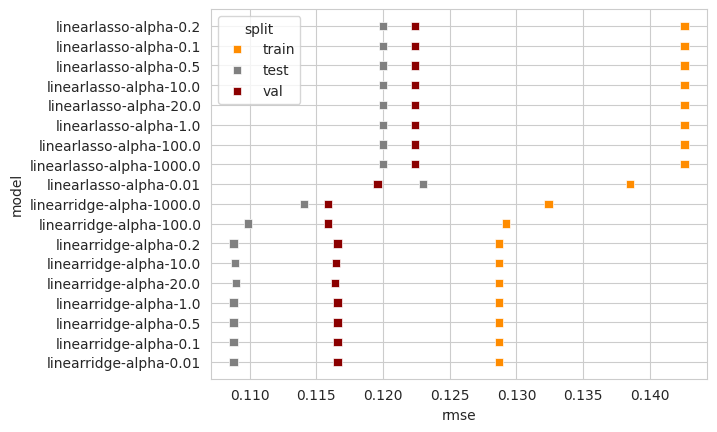

In [94]:
sns.scatterplot(data=regularisation_performance_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])

<Axes: xlabel='rmse', ylabel='model'>

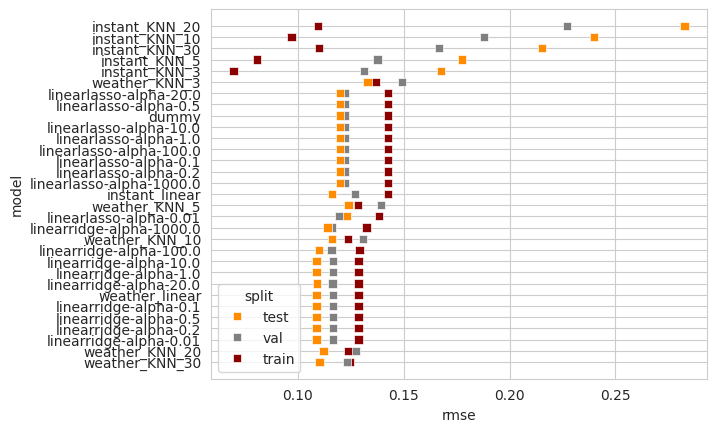

In [95]:
all_performances = pd.concat([performance_df, regularisation_performance_df])

sns.scatterplot(data=all_performances.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])

In [96]:
coefs = pd.DataFrame(np.vstack([v.coef_.round(4) for v in models.values()]),
                     columns=weather_cols)
coefs['mtype'] = [k.split('-')[0] for k in models.keys()]
coefs['alpha'] = [float(k.split('-')[1]) for k in models.keys()]
coefs = pd.melt(coefs, id_vars=['mtype', 'alpha'])# turning data into long format 

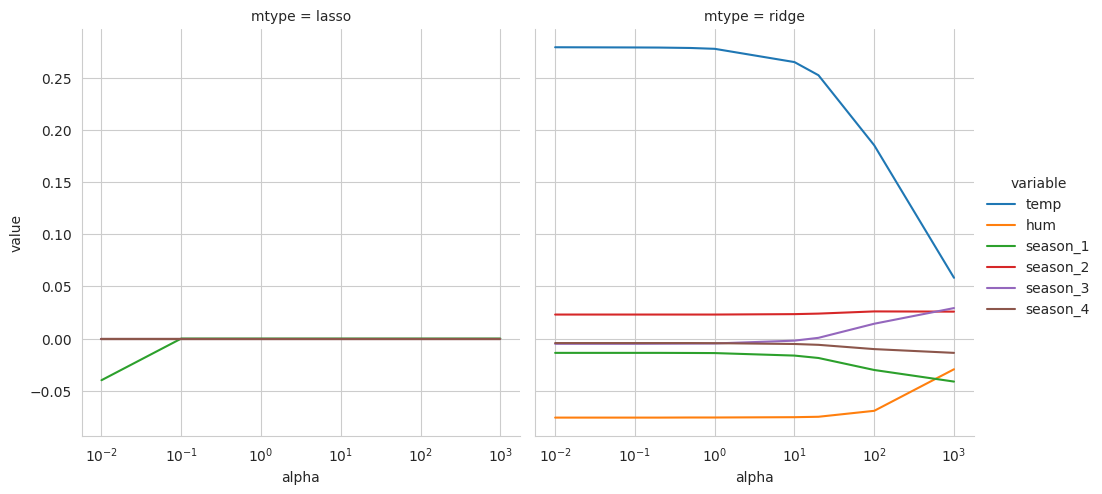

In [97]:
grid = sns.relplot(data=coefs[coefs['mtype']!='linear'], 
                   x='alpha', y='value', 
                   hue='variable', col='mtype', kind='line')
grid.set(xscale="log")

In [98]:
regularisation_performance_df[regularisation_performance_df['split']=='test'].sort_values(by='rmse', ascending=True)

,model,split,rmse,r2
0,linearridge-alpha-0.01,test,0.1088,0.1177
0,linearridge-alpha-0.1,test,0.1088,0.1177
0,linearridge-alpha-0.5,test,0.1088,0.1176
0,linearridge-alpha-0.2,test,0.1088,0.1177
0,linearridge-alpha-1.0,test,0.1088,0.1176
0,linearridge-alpha-10.0,test,0.1089,0.1165
0,linearridge-alpha-20.0,test,0.1090,0.1150
0,linearridge-alpha-100.0,test,0.1099,0.1004
0,linearridge-alpha-1000.0,test,0.1141,0.0296
0,linearlasso-alpha-20.0,test,0.1200,-0.0734


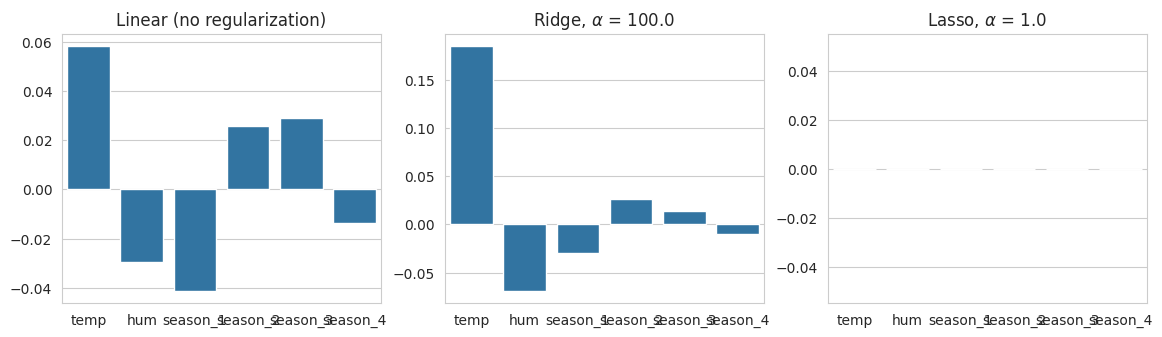

In [100]:
fig, ax = plt.subplots(ncols=3, figsize=(14,3.5))
sns.barplot(x=weather_cols, y=models['lasso-1.0'].coef_, ax=ax[2], color=sns.color_palette()[0])
sns.barplot(x=weather_cols, y=models['ridge-100.0'].coef_, ax=ax[1], color=sns.color_palette()[0])
sns.barplot(x=weather_cols, y=models['linear-0.0'].coef_, ax=ax[0], color=sns.color_palette()[0])
ax[2].set_title('Lasso, $\\alpha$ = 1.0')
ax[1].set_title('Ridge, $\\alpha$ = 100.0')
ax[0].set_title('Linear (no regularization)')
plt.show()